In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
class Predictor:
    def __init__(self):
        self.a = np.random.randn()
        self.b = np.random.randn()
        self.accuracy = np.random.rand()
        self.condition = np.random.choice([0, 1, '#'], size=12)
    
    def is_active(self, prices, dividends):
        return True
    
    def predict(self, prices, dividends):
        if len(prices) == 0 or len(dividends) == 0:
            return 0
        return self.a * (prices[-1] + dividends[-1]) + self.b

    def update_accuracy(self, p_t, d_t, p_t_prev, theta):
        if p_t_prev == 0:
            predicted_value = self.predict([], [d_t])
        else:
            predicted_value = self.predict([p_t_prev], [d_t])
        error = (p_t + d_t - predicted_value) ** 2
        self.accuracy = (1 - theta) * self.accuracy + theta * error

In [25]:
class Trader:
    def __init__(self, lambda_, theta, x_min, x_max):
        self.lambda_ = lambda_
        self.theta = theta
        self.x_min = x_min
        self.x_max = x_max
        self.predictors = [Predictor() for _ in range(10)]
    
    def predict(self, prices, dividends):
        active_predictors = [p for p in self.predictors if p.is_active(prices, dividends)]
        best_predictor = min(active_predictors, key=lambda p: p.accuracy, default=self.predictors[0])
        return best_predictor.predict(prices, dividends), best_predictor.accuracy
    
    def calculate_demand(self, E_ti, sigma_ti, p_t, rf):
        demand = (E_ti - (1 + rf) * p_t) / (self.lambda_ * sigma_ti)
        return np.clip(demand, self.x_min, self.x_max)

    def update_accuracy(self, p_t, d_t, p_t_prev):
        for predictor in self.predictors:
            predictor.update_accuracy(p_t, d_t, p_t_prev, self.theta)

In [29]:
class Market:
    def __init__(self, num_traders, num_periods, dividend_mean, phi, rf, lambda_, theta, x_min, x_max):
        self.num_traders = num_traders
        self.num_periods = num_periods
        self.dividend_mean = dividend_mean
        self.phi = phi
        self.rf = rf
        self.lambda_ = lambda_
        self.theta = theta
        self.x_min = x_min
        self.x_max = x_max
        self.traders = [Trader(lambda_, theta, x_min, x_max) for _ in range(num_traders)]
        self.dividends = np.zeros(num_periods)
        self.prices = np.zeros(num_periods)

    def generate_dividends(self):
        self.dividends[0] = self.dividend_mean  # начальный дивиденд
        for t in range(1, self.num_periods):
            self.dividends[t] = self.dividend_mean + self.phi * (self.dividends[t-1] - self.dividend_mean) + np.random.randn()

    def find_equilibrium_price(self, demands):
        def total_demand_at_price(p):
            return np.sum([trader.calculate_demand(*trader.predict(self.prices, self.dividends), p, self.rf) for trader in self.traders])

        p_low, p_high = 0, 2 * np.mean(demands)  # начальные границы поиска
        while p_high - p_low > 1e-3:  # условие остановки
            p_mid = (p_low + p_high) / 2
            if total_demand_at_price(p_mid) > self.num_traders:
                p_low = p_mid
            else:
                p_high = p_mid
        return (p_low + p_high) / 2
        
    def run_market(self):
        self.generate_dividends()
        for t in range(self.num_periods):
            demands = np.zeros(self.num_traders)
            for i, trader in enumerate(self.traders):
                E_ti, sigma_ti = trader.predict(self.prices[:t], self.dividends[:t])
                demands[i] = trader.calculate_demand(E_ti, sigma_ti, self.prices[t-1] if t > 0 else 0, self.rf)
            self.prices[t] = self.find_equilibrium_price(demands)
            for trader in self.traders:
                trader.update_accuracy(self.prices[t], self.dividends[t], self.prices[t-1] if t > 0 else 0)


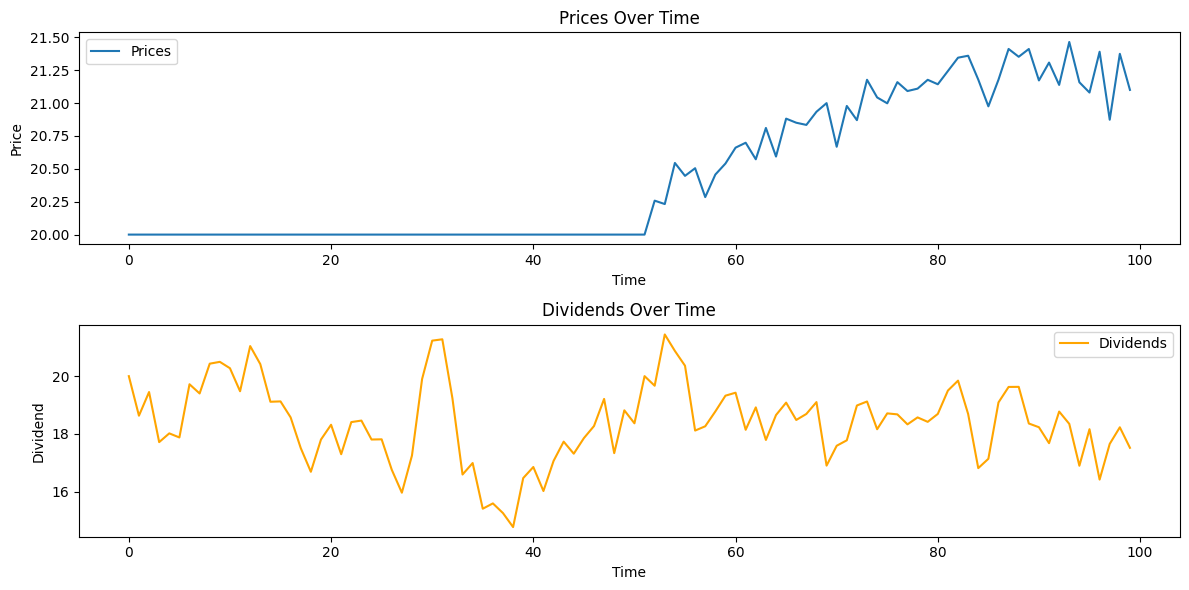

In [40]:
# Параметры модели
num_traders = 10
num_periods = 100
dividend_mean = 20
phi = 0.9
rf = 0.01
lambda_ = 1
theta = 0.1
x_min = 10
x_max = 1000

# Создание рынка и запуск симуляции
market = Market(num_traders, num_periods, dividend_mean, phi, rf, lambda_, theta, x_min, x_max)
market.run_market()

# Построение графиков цен и дивидендов
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(market.prices, label='Prices')
plt.title('Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(market.dividends, label='Dividends', color='orange')
plt.title('Dividends Over Time')
plt.xlabel('Time')
plt.ylabel('Dividend')
plt.legend()

plt.tight_layout()
plt.show()